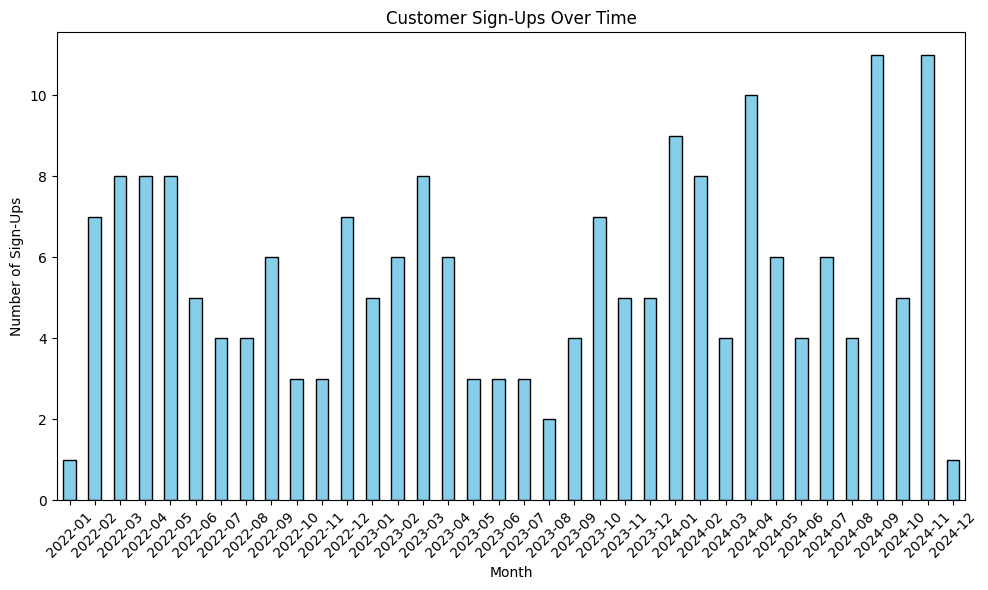

<ipython-input-2-59a58d139b9d>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=products, x="Category", order=products["Category"].value_counts().index, palette="viridis")


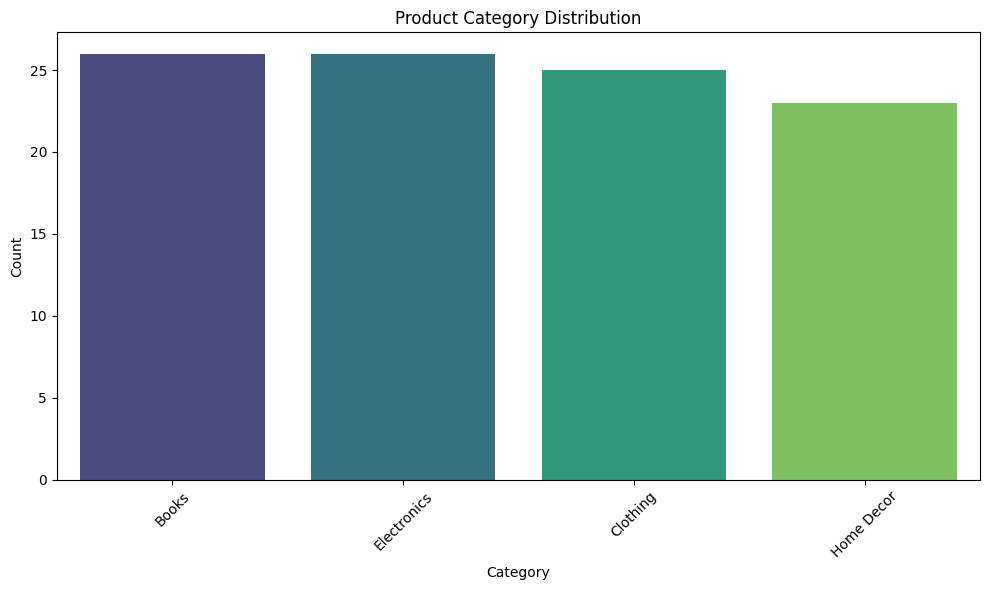

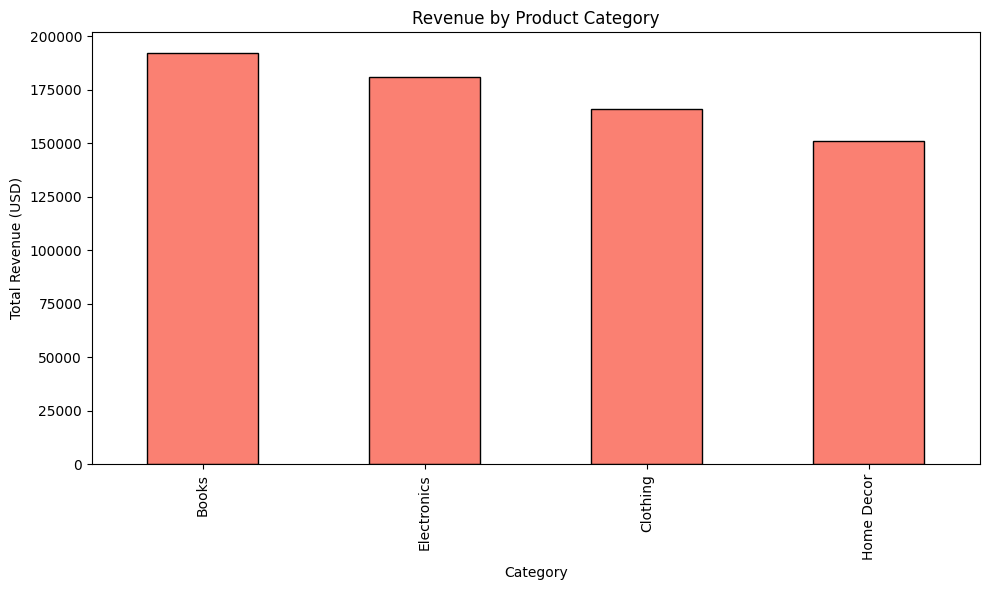

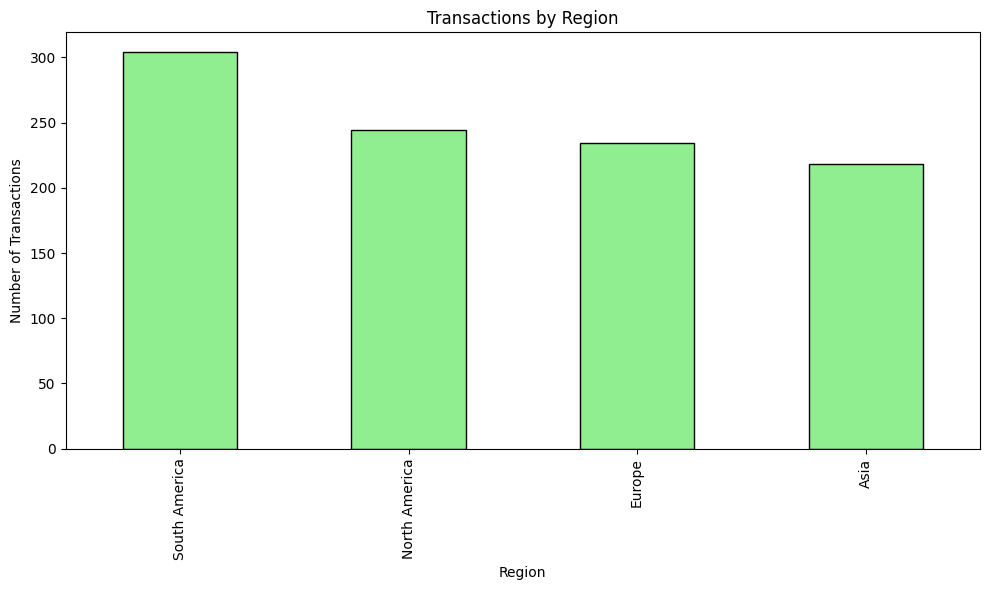

Top 5 Customers by Total Spending:
    CustomerName  TotalValue
0   Paul Parsons    10673.87
1   Bruce Rhodes     8040.39
2   Gerald Hines     7663.70
3  William Adams     7634.45
4   Aimee Taylor     7572.91


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers = pd.read_csv("/Customers.csv")
products = pd.read_csv("/Products.csv")
transactions = pd.read_csv("/Transactions.csv")

# Convert date columns to datetime
customers["SignupDate"] = pd.to_datetime(customers["SignupDate"])
transactions["TransactionDate"] = pd.to_datetime(transactions["TransactionDate"])

# 1. Customer Sign-Up Trends
signups_by_month = customers.groupby(customers["SignupDate"].dt.to_period("M")).size()
plt.figure(figsize=(10, 6))
signups_by_month.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Customer Sign-Ups Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Sign-Ups")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Product Category Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=products, x="Category", order=products["Category"].value_counts().index, palette="viridis")
plt.title("Product Category Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Revenue by Product Category
merged_data = transactions.merge(products, on="ProductID")
revenue_by_category = merged_data.groupby("Category")["TotalValue"].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
revenue_by_category.plot(kind="bar", color="salmon", edgecolor="black")
plt.title("Revenue by Product Category")
plt.xlabel("Category")
plt.ylabel("Total Revenue (USD)")
plt.tight_layout()
plt.show()

# 4. Transactions by Region
transactions_with_region = transactions.merge(customers, on="CustomerID")
transactions_by_region = transactions_with_region["Region"].value_counts()
plt.figure(figsize=(10, 6))
transactions_by_region.plot(kind="bar", color="lightgreen", edgecolor="black")
plt.title("Transactions by Region")
plt.xlabel("Region")
plt.ylabel("Number of Transactions")
plt.tight_layout()
plt.show()

# 5. Top Spending Customers
top_customers = transactions_with_region.groupby("CustomerID")["TotalValue"].sum().nlargest(5)
top_customers = top_customers.reset_index().merge(customers, on="CustomerID")[["CustomerName", "TotalValue"]]
print("Top 5 Customers by Total Spending:")
print(top_customers)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import csv

# Merge datasets
transactions_with_customers = transactions.merge(customers, on="CustomerID").merge(products, on="ProductID")

# Feature Engineering
customer_features = transactions_with_customers.groupby("CustomerID").agg({
    "TotalValue": "sum",
    "Quantity": "sum",
    "Region": lambda x: x.mode()[0],  # Most frequent region
    "Category": lambda x: x.mode()[0]  # Most frequent category
}).reset_index()

# One-hot encode Region and Category
customer_features_encoded = pd.get_dummies(customer_features, columns=["Region", "Category"], drop_first=True)

# Normalize data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features_encoded.drop(columns=["CustomerID"]))

# Cosine Similarity
similarity_matrix = cosine_similarity(scaled_features)
similarity_df = pd.DataFrame(similarity_matrix, index=customer_features["CustomerID"], columns=customer_features["CustomerID"])

# Top 3 Recommendations
lookalike_results = {}
for customer_id in customer_features["CustomerID"][:20]:
    similar_customers = similarity_df[customer_id].nlargest(4).iloc[1:]  # Exclude self
    lookalike_results[customer_id] = list(zip(similar_customers.index, similar_customers.values))

# Save to Lookalike.csv
with open("Lookalike.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["CustomerID", "Lookalikes"])
    for customer, lookalikes in lookalike_results.items():
        lookalikes_str = "; ".join([f"{cust_id}:{score:.4f}" for cust_id, score in lookalikes])
        writer.writerow([customer, lookalikes_str])

print("Lookalike results saved to 'Lookalike.csv'")


Lookalike results saved to 'Lookalike.csv'


Davies-Bouldin Index: 1.6912680288924387


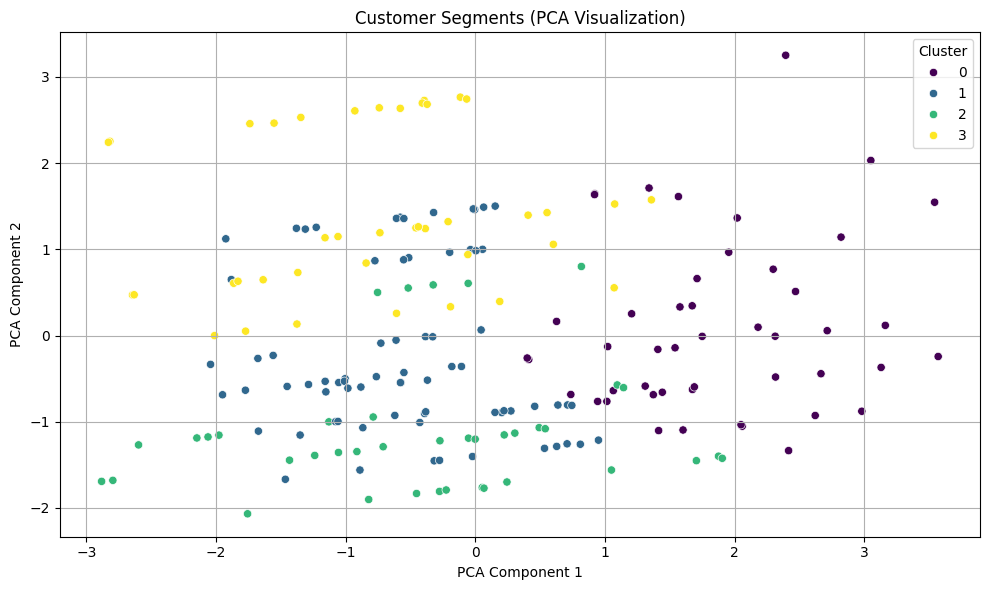

Customer segmentation results saved to 'Customer_Segments.csv'


In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
customer_features["Cluster"] = clusters

# DB Index
db_index = davies_bouldin_score(scaled_features, clusters)
print(f"Davies-Bouldin Index: {db_index}")

# PCA Visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=customer_features["Cluster"], palette="viridis")
plt.title("Customer Segments (PCA Visualization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid()
plt.tight_layout()
plt.show()

# Save Clusters
customer_features[["CustomerID", "Cluster"]].to_csv("Customer_Segments.csv", index=False)
print("Customer segmentation results saved to 'Customer_Segments.csv'")
